In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Load the dataset

In [33]:
file_path = './online_shoppers_intention.csv'
data = pd.read_csv(file_path)

# Define feature types

In [34]:
numerical_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                      'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
                      'SpecialDay']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']


# Define target

In [35]:
target = 'Revenue'


# Step 1: Data Preprocessing
# Preprocess numerical and categorical features

In [36]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors into a single ColumnTransformer


In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Step 2: Model Selection

In [38]:
models = {
    'DecisionTree': DecisionTreeClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, algorithm='SAMME')
}

# Step 3: Train/Test Split

In [39]:
X = data.drop(target, axis=1)
y = data[target]


# Splitting the dataset into training and test sets (80% training, 20% testing)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Function for evaluating the models

In [41]:
def evaluate_model(clf, model_name):
    # Train the model on the full training set
    clf.fit(X_train, y_train)
    
    # Evaluate on the test set
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

# Step 4: Cross-validation (5-fold, 80% training data) - Requirement 1


In [42]:
results = {}
for model_name, model in models.items():
    # Create pipeline with preprocessing and model
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    # Cross-validation (5-fold)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validated accuracy for {model_name}: {scores.mean():.4f}")
    
    # Evaluate the model and store results
    results[model_name] = evaluate_model(clf, model_name)

Cross-validated accuracy for DecisionTree: 0.8597
Cross-validated accuracy for LogisticRegression: 0.8870
Cross-validated accuracy for KNN: 0.8750
Cross-validated accuracy for AdaBoost: 0.8620


# Step 5: Random Sampling (50% of the data) - Requirement 2


In [43]:
random_results = {}
for model_name, model in models.items():
    model_scores = []
    for i in range(5):
        # Randomly sample 50% of the training data
        X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=i)
        clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        
        # Fit and evaluate the model
        clf.fit(X_train_sample, y_train_sample)
        model_scores.append(evaluate_model(clf, model_name))
    
    # Store the scores for random sampling
    random_results[model_name] = model_scores


# Step 6: AdaBoost (5 Models) - Requirement 3


In [44]:
adaboost_results = []
for i in range(5):
    # Train AdaBoost on the full training set, repeat 5 times
    ada_boost_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, algorithm='SAMME')
    ada_boost_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', ada_boost_model)])
    # y_train=np.where(y_train==0,-1,y_train)
    ada_boost_pipeline.fit(X_train, y_train)
    adaboost_results.append(evaluate_model(ada_boost_pipeline, "AdaBoost"))



# Step 7: Feature Importance for AdaBoost

In [45]:
def plot_feature_importance(model, X_train, model_name):
    # Get feature names after transformation
    feature_names = numerical_features + list(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features))
    
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        # Get feature importances from models that support it
        importance = model.named_steps['classifier'].feature_importances_
    else:
        # For models that do not support feature_importances_, use permutation importance
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
        importance = result.importances_mean
    
    # Ensure the number of importances matches the number of features
    if len(importance) != len(feature_names):
        print(f"Warning: Number of importances ({len(importance)}) does not match the number of features ({len(feature_names)}).")
    
    # Create a DataFrame for feature importances and plot
    feature_importances = pd.Series(importance, index=feature_names)
    feature_importances.nlargest(10).plot(kind='barh')
    plt.title(f'Feature Importance for {model_name}')
    plt.show()

# AdaBoost Pipeline

In [46]:
ada_boost_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, algorithm='SAMME'))])
ada_boost_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Administrative',
                                                   'Administrative_Duration',
                                                   'Informational',
                                                   'Informational_Duration',
                                                   'ProductRelated',
                                                   'ProductRelated_Duration',
                                                   'BounceRates', 'ExitRates',
                                                   'PageValues',
                                                   'SpecialDay']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Month', 'OperatingSystems',
                                                   'Browser', 'Region',
                                                   'TrafficType', 'VisitorType',
                                                   'Weekend'])])),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier()))])

# Plot the feature importances


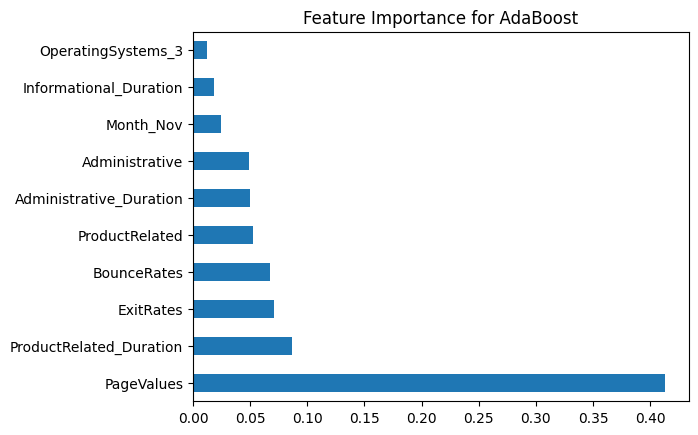

In [47]:
plot_feature_importance(ada_boost_pipeline, X_train, "AdaBoost")


# Display results


In [48]:
# Cross-Validation Results (this is fine)
results_df = pd.DataFrame(results).T

# Random Sampling (50% of the data) Results
# Convert each model's random sampling results into a DataFrame
random_results_dfs = {}
for model_name, model_scores in random_results.items():
    random_results_dfs[model_name] = pd.DataFrame(model_scores)

# AdaBoost Results (this is fine)
adaboost_results_df = pd.DataFrame(adaboost_results)

# Display Results
print("Cross-Validation Results:")
print(results_df)

print("\nRandom 50% Sampling Results (each model has a separate DataFrame):")
for model_name, df in random_results_dfs.items():
    print(f"\nRandom Sampling Results for {model_name}:")
    print(df)

print("\nAdaBoost Results:")
print(adaboost_results_df)


Cross-Validation Results:
                    Accuracy Precision    Recall  F1 Score       AUC  \
DecisionTree        0.852393  0.555556  0.571776  0.563549  0.740146   
LogisticRegression  0.871046  0.736041  0.352798  0.476974  0.889788   
KNN                 0.868613  0.700461   0.36983  0.484076   0.78366   
AdaBoost            0.848743  0.544393   0.56691  0.555423   0.73601   

                             Confusion Matrix  
DecisionTree        [[1867, 188], [176, 235]]  
LogisticRegression   [[2003, 52], [266, 145]]  
KNN                  [[1990, 65], [259, 152]]  
AdaBoost            [[1860, 195], [178, 233]]  

Random 50% Sampling Results (each model has a separate DataFrame):

Random Sampling Results for DecisionTree:
   Accuracy  Precision    Recall  F1 Score       AUC  \
0  0.855637   0.566265  0.571776  0.569007  0.742092   
1  0.855231   0.564593  0.574209  0.569361  0.742822   
2  0.853609   0.558962  0.576642  0.567665  0.742822   
3  0.847526   0.541176  0.559611  0.55

# Predict using AdaBoost on the test set

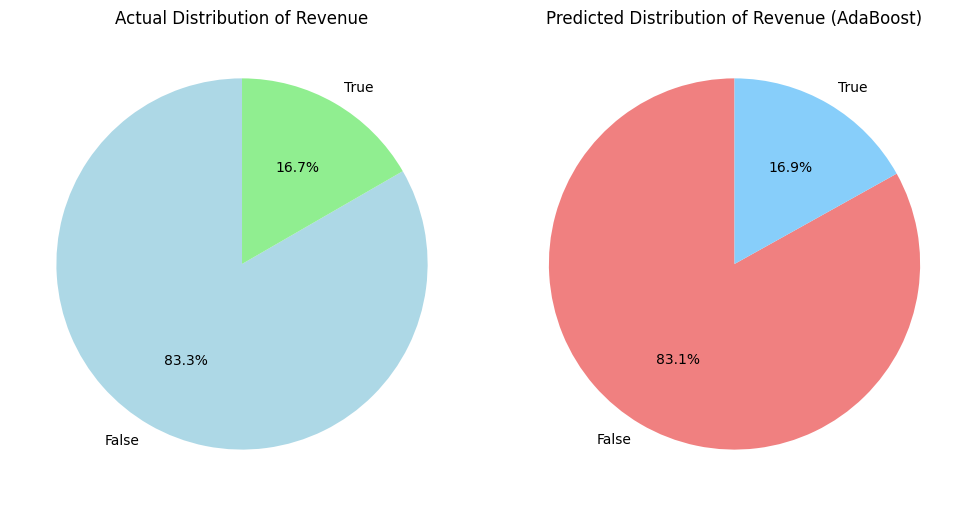

In [49]:
y_pred_ada = ada_boost_pipeline.predict(X_test)

# Count the occurrences of each class (0 and 1) for actual and predicted values
actual_counts = y_test.value_counts()
predicted_counts = pd.Series(y_pred_ada).value_counts()

# Plot the pie chart for actual values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(actual_counts, labels=actual_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightgreen'], startangle=90)
plt.title('Actual Distribution of Revenue')

# Plot the pie chart for predicted values
plt.subplot(1, 2, 2)
plt.pie(predicted_counts, labels=predicted_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'], startangle=90)
plt.title('Predicted Distribution of Revenue (AdaBoost)')

plt.tight_layout()
plt.show()



# Group by Month and sum the Revenue column to count purchases (Revenue = 1)


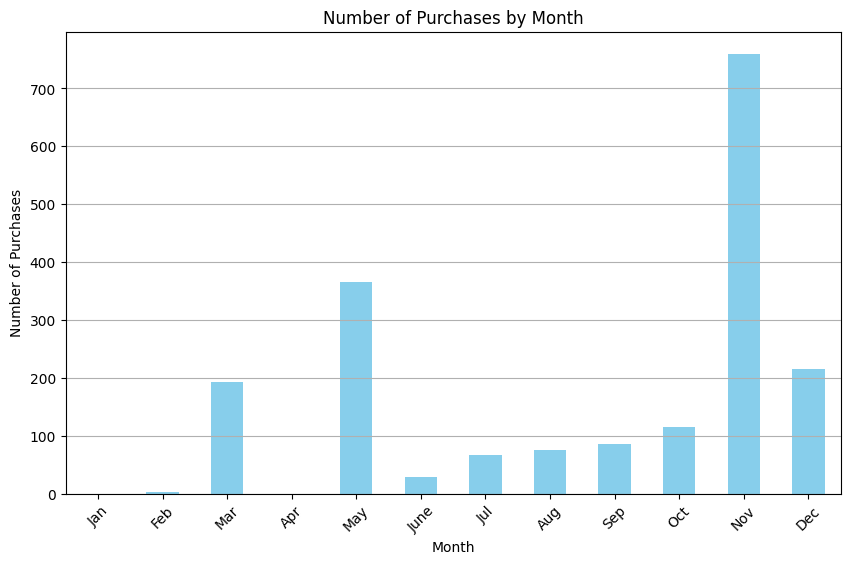

In [50]:
monthly_purchases = data.groupby('Month')['Revenue'].sum()

# Sort months in order if needed
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_purchases = monthly_purchases.reindex(month_order)

# Plot the bar chart
plt.figure(figsize=(10, 6))
monthly_purchases.plot(kind='bar', color='skyblue')

plt.title('Number of Purchases by Month')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


# Scatter plot of PageValues vs. Revenue

<Figure size 800x600 with 0 Axes>

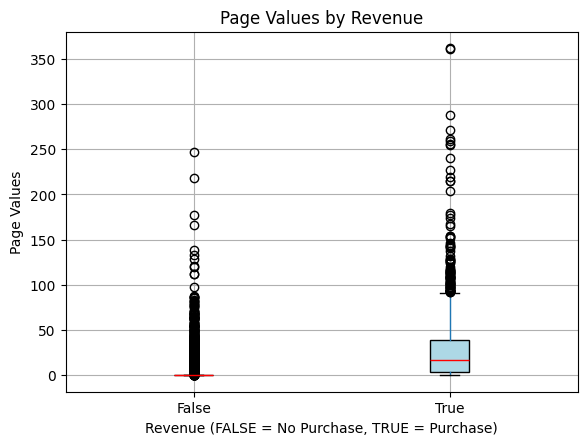

In [51]:

plt.figure(figsize=(8, 6))
data.boxplot(column='PageValues', by='Revenue', grid=False, patch_artist=True,
             boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))

plt.title('Page Values by Revenue')
plt.suptitle('')  # Suppress the automatic title from `boxplot`
plt.xlabel('Revenue (FALSE = No Purchase, TRUE = Purchase)')
plt.ylabel('Page Values')
plt.grid(True)
plt.show()

